In [8]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from collections import defaultdict
import re
import ast
from scipy.stats import linregress
from matplotlib.dates import DateFormatter
from scipy.stats import kurtosis, skew

This notebook performs the sentiment analysis part of this research. It is divided into two segments:

1. Concatenation and cleaning of GenAI-sentimented AllSpeaches.csv file into final AllSpeachesSent.csv
2. Enriching plain AllSpeaches_Sent_GenAI.csv file with FinBERT sentiment analysis


Inputs:
- __"AllSpeaches_Sent_GenAI.csv"__ = Results of manual sentiment analysis performed with the help of Generative AI.
- __"NewVars.csv"__ = shortcut to skip 200+ minutes of FinBERT sentiment analysis
- __"AllSpeaches.csv"__ = Central bank public statement raw information file 

Output:
- __"AllSpeachesSent".csv__ = File containing fully sentimented central bank information ready for modelling exercise before feature engineering (those will be added in the concatenation notebook).

## Fixing manual errors caused during GenAI sentiment calculation

In [2]:
AllSpeaches = pd.read_csv("AllSpeaches_Sent_GenAI.csv", sep=';').iloc[:, 1:]
AllSpeaches

,Date,Title,Topic,Speaker,Content,Sentiment,Decision
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,0.50,“The provided text predominantly offers factua...
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,0.55,“The score is derived from the neutral yet sli...
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,0.57,"""The text's focus on enhancing governance and ..."
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,0.60,"""The announcement of the termination of an enf..."
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,0.55,“The content's focus on interest rate adjustme...
...,...,...,...,...,...,...,...
1722,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,0.80,“This text reflects a positive development wit...
1723,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...",0.60,“Isabel Schnabel's speech offers a nuanced per...
1724,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,0.50,"“The document's tone is neutral, focusing on p..."
1725,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...",0.60,“Isabel Schnabel's speech provides a detailed ...


### MISMATCHED Rows:
- (Fixed) 2 speeches missing decision
- (Fixed)10 too long statements
- (Fixed) 71 missing texts
- (Dropped) 1 Truly missing text - not enough information
- (Dropped) 3 duplicate statements with similar message -> deleting duplicates

In [3]:
# Manually fixed GenAI output issues, see the text above and chapter three - no NaN sentiment anymore

AllSpeaches[AllSpeaches["Sentiment"].isna()==True]

,Date,Title,Topic,Speaker,Content,Sentiment,Decision


In [4]:
# Test to check whether the numbers in Sentiment column align the predefined format, to be further rescaled
((AllSpeaches["Sentiment"] > 0) & (AllSpeaches["Sentiment"] < 1)).sum() / len(AllSpeaches["Sentiment"])

1.0

It does, all good!

In [5]:
# Removing previously defined duplicates in last point of "Mismatched rows" list
indices_to_drop = [x for x in AllSpeaches[AllSpeaches.apply(lambda x: x.duplicated().any(), axis=1) == True].index]
indices_to_drop

[1302, 1303, 1304]

In [6]:
# Still one remaining MISSING entry, let's remove this one.
for x in AllSpeaches[AllSpeaches["Decision"] == '“MISSING”'].index:
    indices_to_drop.append(x)

In [7]:
indices_to_drop.sort()
indices_to_drop

[623, 1302, 1303, 1304]

In [8]:
AllSpeaches["Topic"][623]

'OTHER PUBLICATION'

In [9]:
AllSpeaches.drop(indices_to_drop, inplace=True)
AllSpeaches.reset_index(drop=True, inplace=True)
AllSpeaches

,Date,Title,Topic,Speaker,Content,Sentiment,Decision
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,0.50,“The provided text predominantly offers factua...
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,0.55,“The score is derived from the neutral yet sli...
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,0.57,"""The text's focus on enhancing governance and ..."
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,0.60,"""The announcement of the termination of an enf..."
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,0.55,“The content's focus on interest rate adjustme...
...,...,...,...,...,...,...,...
1718,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,0.80,“This text reflects a positive development wit...
1719,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...",0.60,“Isabel Schnabel's speech offers a nuanced per...
1720,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,0.50,"“The document's tone is neutral, focusing on p..."
1721,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...",0.60,“Isabel Schnabel's speech provides a detailed ...


In [10]:
# Checking for previously defined errors
AllSpeaches[AllSpeaches["Decision"] == '“TOO LONG”']["Content"].index

Index([], dtype='int64')

In [11]:
def get_elements_of_type(arr, desired_type):
    return [el for el in arr if isinstance(el, desired_type)]

# Verifying null statements
type_counts = defaultdict(int)

# Iterate through the array and update counts
for element in AllSpeaches["Content"].values:
    type_counts[type(element).__name__] += 1

# Display the statistics
for dtype, count in type_counts.items():
    print(f"{dtype}: {count}")

str: 1722
float: 1


As can be seen, there is one case of non-texts. Let's further investigate this one.

In [12]:
AllSpeaches[AllSpeaches["Content"].isna()]

,Date,Title,Topic,Speaker,Content,Sentiment,Decision
497,2019-01-31,Report,OTHER PUBLICATION,ECB,NaN,0.5,"“The sentiment of the document is neutral, as ..."


In [13]:
# Retrieve all strings
strings = get_elements_of_type(AllSpeaches["Content"].values, float)
print(strings) 

[nan]


This is only an empty string, yet with full sentiment analysis, which is most likely only a mistake in versioning. Let's remove it.

In [14]:
AllSpeaches.drop(497, axis=0, inplace=True)

In [15]:
AllSpeaches.reset_index(inplace=True, drop=True)
AllSpeaches

,Date,Title,Topic,Speaker,Content,Sentiment,Decision
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,0.50,“The provided text predominantly offers factua...
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,0.55,“The score is derived from the neutral yet sli...
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,0.57,"""The text's focus on enhancing governance and ..."
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,0.60,"""The announcement of the termination of an enf..."
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,0.55,“The content's focus on interest rate adjustme...
...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,0.80,“This text reflects a positive development wit...
1718,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...",0.60,“Isabel Schnabel's speech offers a nuanced per...
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,0.50,"“The document's tone is neutral, focusing on p..."
1720,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...",0.60,“Isabel Schnabel's speech provides a detailed ...


## FinBERT Sentiment Analysis

Now we have the speech dataset prepared. Let's start the sentiment analysis!

In [11]:
# Loading the FinBERT model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer_config.json: 100%|██████████| 252/252 [00:00<00:00, 254kB/s]
C:\Users\vikrejcar\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vikrejcar\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config.json: 100%|███████

In [12]:
# Defining additional functions to process speaches

def split_and_process_text(s, chars):
    # Email regex pattern
    email_pattern = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"
    
    # Percentage regex pattern (to capture values like "50.5%")
    percentage_pattern = r"\d+\.\d+%"

    # Adjust the split pattern to exclude dots followed by non-space characters,
    # and to exclude the patterns that match emails and percentage values
    try:
        chars.remove(".")
    except ValueError:
        pass
    pattern = '|'.join(map(re.escape, chars))
    pattern += r"|(?<!\.)\.(?=\s|$)(?!{})(?!{})".format(email_pattern, percentage_pattern)

    # Split the string based on the pattern
    split_result = re.split(pattern, s)
    
    # Process each split segment to replace multiple spaces with a single space
    processed_result = [re.sub(r'\s+', ' ', segment).strip() for segment in split_result]
    
    return processed_result


def extract_sentiment(speech):
    speechlen = len(speech)
    inputs = tokenizer(speech, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probs, dim=-1)
    weights = torch.tensor([1.0, -1.0, 0])
    sentiment_scores = probs @ weights
    return [probs, predicted_label, sentiment_scores]


def mean_of_list(numbers):
    return sum(numbers) / len(numbers)

In [22]:
# runned for ~232 mins
inpts = [text for text in AllSpeaches["Content"].values]
print(len(inpts))

# Separator values:
chars = [".", "?", "!"]
probabilities = []
predictions = []
sentiments = []

for i, speech in enumerate(inpts):
    if i % 50 == 0:
        print(f"Currently processing speech number: {i+1}/{len(inpts)}")
    split = split_and_process_text(speech, chars) 
    current_probabilities = []
    current_predictions = []
    current_sentiments = []
    for sentence in split:
        result = extract_sentiment(sentence)
        current_probabilities.append(result[0].tolist())
        current_predictions.append(result[1].item())
        current_sentiments.append(round(result[2].item(), 3))
    
    probabilities.append(current_probabilities)
    predictions.append(current_predictions)
    sentiments.append(current_sentiments)

1722
Currently processing speech number: 1/1722
Currently processing speech number: 51/1722
Currently processing speech number: 101/1722
Currently processing speech number: 151/1722
Currently processing speech number: 201/1722
Currently processing speech number: 251/1722
Currently processing speech number: 301/1722
Currently processing speech number: 351/1722
Currently processing speech number: 401/1722
Currently processing speech number: 451/1722
Currently processing speech number: 501/1722
Currently processing speech number: 551/1722
Currently processing speech number: 601/1722
Currently processing speech number: 651/1722
Currently processing speech number: 701/1722
Currently processing speech number: 751/1722
Currently processing speech number: 801/1722
Currently processing speech number: 851/1722
Currently processing speech number: 901/1722
Currently processing speech number: 951/1722
Currently processing speech number: 1001/1722
Currently processing speech number: 1051/1722
Curren

In [23]:
newvars = {"Sentiments" : sentiments,
           "Probabilities" : probabilities,
           "Predictions" : predictions
}

newvars = pd.DataFrame(newvars)
newvars = {"Probabilities": probabilities,
           "Sentiments": sentiments,
           "Predictions": predictions}
newvars = pd.DataFrame(newvars)

In [78]:
AllSpeaches.reset_index(drop=True, inplace=True)

# Since the numbers have been imputed as strings, let's convert those into a list
for i in newvars.columns:
    newvars[i] = newvars[i].apply(ast.literal_eval)
    
newvars

Probabilities    object
Sentiments       object
Predictions      object
dtype: object

## Concatenation of the two sentiments

Skip to here if don't want to wait for FinBERT sentiment analysis

In [16]:
newvars = pd.read_csv("NewVars.csv").iloc[:,1:]
newvars

,Probabilities,Sentiments,Predictions
0,"[[[0.01726001501083374, 0.07022946327924728, 0...","[-0.053, -0.014, -0.026, -0.018, -0.013]","[2, 2, 2, 2, 2]"
1,"[[[0.2957149147987366, 0.010425006039440632, 0...","[0.285, -0.008, 0.004, -0.016]","[2, 2, 2, 2]"
2,"[[[0.09247113019227982, 0.02066551335155964, 0...","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
3,"[[[0.022193213924765587, 0.18937931954860687, ...","[-0.167, 0.004, 0.143]","[2, 2, 2]"
4,"[[[0.018251681700348854, 0.10139124095439911, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ..."
...,...,...,...
1717,"[[[0.045068830251693726, 0.028403133153915405,...","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
1718,"[[[0.9199861884117126, 0.02911015972495079, 0....","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ..."
1719,"[[[0.033436767756938934, 0.03101201541721821, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1720,"[[[0.40540656447410583, 0.5609546303749084, 0....","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ..."


In [17]:
joined = AllSpeaches.join(newvars, how='outer')
# Creating a list out of the string
joined['Sentiments'] = joined['Sentiments'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() != '' else [])
joined['MeanSent'] = joined['Sentiments'].apply(lambda x: sum(x)/len(x))
joined['MaxSent'] = joined['Sentiments'].apply(max)
joined['MinSent'] = joined['Sentiments'].apply(min)
joined = joined[["Date", "Title", "Topic", "Speaker", "Content", "Probabilities", "Predictions", "Sentiments", "MeanSent", "MaxSent", "MinSent",  "Sentiment", "Decision"]]
joined

,Date,Title,Topic,Speaker,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ..."
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf..."
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...
1718,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p..."
1720,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...


In [18]:
# Rescaling GenAI sentiment to be in [-1;1] range
joined["SentimentRes"] = 2 * joined["Sentiment"] - 1

# Creating variable signalling the difference between FinBERT and GenAi
joined["Difference"] = joined["SentimentRes"] - joined["MeanSent"]
joined

,Date,Title,Topic,Speaker,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769
1718,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647
1720,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409


In [19]:
# Saving the pre-final dataset before aggregation
joined.to_csv('AllSpeachesSent.csv')

## Fixing the issue of speakers
Since the column "Speaker" is not 100% reflective of the reality, it needs to be corrected from the sources.

In [20]:
# Reading dataset with correct labels:
correct = pd.read_csv("AllSpeaches.csv") 
print(correct["Speaker"].value_counts())
correct.shape

Speaker
FED    968
ECB    759
Name: count, dtype: int64


(1727, 6)

In [21]:
mrgd = pd.merge(joined, correct[["Date", "Title", "Topic", "Speaker"]], how="left", on=["Title", "Date"])
mrgd

,Date,Title,Topic_x,Speaker_x,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference,Topic_y,Speaker_y
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800,PressRelease,FED
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750,PressRelease,FED
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812,PressRelease,FED
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667,PressRelease,FED
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545,PressRelease,FED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769,PRESS RELEASE,ECB
1722,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766,Speech,ECB
1723,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647,Speech,ECB
1724,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409,Speech,ECB


Results are in shape (1726, 17) -> duplicate rows that needs to be addressed!

In [22]:
mrgd.duplicated('Content', keep=False).sum()

8

In [23]:
# Unwanted duplicates
mrgd = mrgd.drop_duplicates('Content', keep='first')
mrgd.reset_index(drop=True, inplace=True)
mrgd

,Date,Title,Topic_x,Speaker_x,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference,Topic_y,Speaker_y
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",NaN,FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800,PressRelease,FED
1,2018-01-03,Federal Reserve Board announces approval of ap...,NaN,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750,PressRelease,FED
2,2018-01-04,Federal Reserve Board requests comment on prop...,NaN,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812,PressRelease,FED
3,2018-01-04,Federal Reserve Board announces termination of...,NaN,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667,PressRelease,FED
4,2018-01-09,Minutes of the Board's discount rate meetings ...,NaN,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545,PressRelease,FED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769,PRESS RELEASE,ECB
1718,2021-09-13,New narratives on monetary policy – the spectr...,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766,Speech,ECB
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,Philip R. Lane,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647,Speech,ECB
1720,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,Isabel Schnabel,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409,Speech,ECB


All good!

In [24]:
# Renaming and rearranging columns
mrgd.drop(["Topic_x", "Speaker_x"], axis=1, inplace=True)
mrgd.columns =  ['Date', 'Title', 'Content', 'Probabilities', 'Predictions',
       'Sentiments', 'MeanSent', 'MaxSent', 'MinSent', 'Sentiment', 'Decision',
       'SentimentRes', 'Difference', 'Topic', 'Speaker']
mrgd = mrgd[['Date', 'Title', 'Topic', 'Speaker', 'Content', 'Probabilities', 'Predictions',
       'Sentiments', 'MeanSent', 'MaxSent', 'MinSent', 'Sentiment', 'Decision',
       'SentimentRes', 'Difference']]
mrgd

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_16206/2997796869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd.drop(["Topic_x", "Speaker_x"], axis=1, inplace=True)


,Date,Title,Topic,Speaker,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",PressRelease,FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800
1,2018-01-03,Federal Reserve Board announces approval of ap...,PressRelease,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750
2,2018-01-04,Federal Reserve Board requests comment on prop...,PressRelease,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812
3,2018-01-04,Federal Reserve Board announces termination of...,PressRelease,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667
4,2018-01-09,Minutes of the Board's discount rate meetings ...,PressRelease,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769
1718,2021-09-13,New narratives on monetary policy – the spectr...,Speech,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,ECB,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647
1720,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409


In [25]:
# Still missings, let's fix that!
print(mrgd["Topic"].isna().sum())
mrgd["Speaker"].isna().sum()

18


18

In [26]:
# Unfortunately manually imputing the correct values :/
truesspeak = ["ECB", "ECB", "ECB", "ECB", "FED", "ECB", "FED", "FED", "ECB", "FED", "ECB", "ECB", "ECB", "FED", "ECB", "ECB", "ECB", "ECB"]
truestopic = ["Speech", "Speech", "PRESS RELEASE", "PRESS RELEASE", "PRESS RELEASE", "Speech", "PRESS RELEASE", "PRESS RELEASE", "PRESS RELEASE", "PRESS RELEASE", "PRESS RELEASE", "SPEECH", "PRESS RELEASE", "SPEECH", "SPEECH", "PRESS RELEASE", "SPEECH", "PRESS RELEASE"]
subset = mrgd[mrgd["Topic"].isna() == True]
for i, index in enumerate(mrgd[mrgd["Topic"].isna() == True].index):
    mrgd["Speaker"][index] = truesspeak[i]
    mrgd["Topic"][index] = truestopic[i]
mrgd.isna().sum()

/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_16206/2161737403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd["Speaker"][index] = truesspeak[i]
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_16206/2161737403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd["Topic"][index] = truestopic[i]
/var/folders/7s/354czh2x135b109q93ctpp3m0000gn/T/ipykernel_16206/2161737403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Date             0
Title            0
Topic            0
Speaker          0
Content          0
Probabilities    0
Predictions      0
Sentiments       0
MeanSent         0
MaxSent          0
MinSent          0
Sentiment        0
Decision         0
SentimentRes     0
Difference       0
dtype: int64

No NaNs!

In [27]:
# Saving the iterated version
mrgd.to_csv("AllSpeachesSent1.csv")

In [18]:
AllSpeaches = pd.read_csv("AllSpeachesSent1.csv").iloc[:,1:]
AllSpeaches

,Date,Title,Topic,Speaker,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",PressRelease,FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800
1,2018-01-03,Federal Reserve Board announces approval of ap...,PressRelease,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750
2,2018-01-04,Federal Reserve Board requests comment on prop...,PressRelease,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812
3,2018-01-04,Federal Reserve Board announces termination of...,PressRelease,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667
4,2018-01-09,Minutes of the Board's discount rate meetings ...,PressRelease,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,PRESS RELEASE,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769
1718,2021-09-13,New narratives on monetary policy – the spectr...,Speech,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,Speech,ECB,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647
1720,2021-09-15,The monetary policy non-puzzle in bond markets,Speech,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409


Done!

In [19]:
# Choosing all other topics of speeches into one of: Speech, Press Release and Monetary Decision
longlist = list(AllSpeaches[AllSpeaches["Speaker"] == "ECB"]["Topic"].value_counts().index)[3:]
AllSpeaches["TopicFin"] = AllSpeaches["Topic"].replace(longlist, "PRESS RELEASE")
AllSpeaches["TopicFin"].value_counts()

TopicFin
PressRelease                747
Speech                      593
PRESS RELEASE               349
MONETARY POLICY DECISION     33
Name: count, dtype: int64

In [20]:
AllSpeaches.drop("Topic", inplace=True, axis=1)
AllSpeaches = AllSpeaches.rename(columns={"TopicFin": "Topic"})
AllSpeaches["Topic"] = AllSpeaches["Topic"].replace("PRESS RELEASE", "PressRelease").replace("MONETARY POLICY DECISION","MonetaryDecision")
AllSpeaches

# Save if needed
# AllSpeaches.to_csv("AllSpeachesSentNonAgg.csv")

,Date,Title,Speaker,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference,Topic
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800,PressRelease
1,2018-01-03,Federal Reserve Board announces approval of ap...,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750,PressRelease
2,2018-01-04,Federal Reserve Board requests comment on prop...,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812,PressRelease
3,2018-01-04,Federal Reserve Board announces termination of...,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667,PressRelease
4,2018-01-09,Minutes of the Board's discount rate meetings ...,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545,PressRelease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769,PressRelease
1718,2021-09-13,New narratives on monetary policy – the spectr...,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766,Speech
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,ECB,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647,Speech
1720,2021-09-15,The monetary policy non-puzzle in bond markets,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409,Speech


## Table Aggregation to daily sentiment

In [21]:
speaker_dummies = pd.get_dummies(AllSpeaches['Speaker'])
topic_dummies = pd.get_dummies(AllSpeaches['Topic'])
AllSpeaches["IsNegativeGenAI"] = (AllSpeaches["SentimentRes"] < 0).astype(int)
AllSpeaches["IsNegativeFinBERT"] = (AllSpeaches["MeanSent"] < 0).astype(int)
AllSpeaches["IsPositiveGenAI"] = (AllSpeaches["SentimentRes"] > 0).astype(int)
AllSpeaches["IsPositiveFinBERT"] = (AllSpeaches["MeanSent"] > 0).astype(int)
AllSpeaches

,Date,Title,Speaker,Content,Probabilities,Predictions,Sentiments,MeanSent,MaxSent,MinSent,Sentiment,Decision,SentimentRes,Difference,Topic,IsNegativeGenAI,IsNegativeFinBERT,IsPositiveGenAI,IsPositiveFinBERT
0,2018-01-03,"Minutes of the Federal Open Market Committee, ...",FED,The Federal Reserve Board and the Federal Open...,"[[[0.01726001501083374, 0.07022946327924728, 0...","[2, 2, 2, 2, 2]","[-0.053, -0.014, -0.026, -0.018, -0.013]",-0.024800,-0.013,-0.053,0.50,“The provided text predominantly offers factua...,0.00,0.024800,PressRelease,0,1,0,0
1,2018-01-03,Federal Reserve Board announces approval of ap...,FED,The Federal Reserve Board on Wednesday announc...,"[[[0.2957149147987366, 0.010425006039440632, 0...","[2, 2, 2, 2]","[0.285, -0.008, 0.004, -0.016]",0.066250,0.285,-0.016,0.55,“The score is derived from the neutral yet sli...,0.10,0.033750,PressRelease,0,0,1,1
2,2018-01-04,Federal Reserve Board requests comment on prop...,FED,The Federal Reserve Board on Thursday requeste...,"[[[0.09247113019227982, 0.02066551335155964, 0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.072, 0.479, 0.097, 0.068, 0.064, 0.058, 0.1...",0.071188,0.479,-0.027,0.57,"""The text's focus on enhancing governance and ...",0.14,0.068812,PressRelease,0,0,1,1
3,2018-01-04,Federal Reserve Board announces termination of...,FED,The Federal Reserve Board on Thursday announce...,"[[[0.022193213924765587, 0.18937931954860687, ...","[2, 2, 2]","[-0.167, 0.004, 0.143]",-0.006667,0.143,-0.167,0.60,"""The announcement of the termination of an enf...",0.20,0.206667,PressRelease,0,1,1,0
4,2018-01-09,Minutes of the Board's discount rate meetings ...,FED,The Federal Reserve Board on Tuesday released ...,"[[[0.018251681700348854, 0.10139124095439911, ...","[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, ...","[-0.083, -0.017, 0.004, 0.435, 0.011, -0.102, ...",0.136545,0.925,-0.851,0.55,“The content's focus on interest rate adjustme...,0.10,-0.036545,PressRelease,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2021-09-13,ECB appoints Isabel Vansteenkiste as Director ...,ECB,PRESS RELEASEECB appoints Isabel Vansteenkiste...,"[[[0.045068830251693726, 0.028403133153915405,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.017, 0.008, -0.013, -0.008, -0.011, 0.031, ...",0.022231,0.143,-0.013,0.80,“This text reflects a positive development wit...,0.60,0.577769,PressRelease,0,0,1,1
1718,2021-09-13,New narratives on monetary policy – the spectr...,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.9199861884117126, 0.02911015972495079, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, ...","[0.891, 0.346, 0.93, 0.903, 0.87, 0.431, 0.871...",0.062234,0.937,-0.967,0.60,“Isabel Schnabel's speech offers a nuanced per...,0.20,0.137766,Speech,0,0,1,1
1719,2021-09-15,The ECB's monetary policy strategy review - IM...,ECB,The ECB’s monetary policy strategy review\nIMF...,"[[[0.033436767756938934, 0.03101201541721821, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.002, 0.049, -0.004, -0.038, 0.01, -0.106, 0...",0.057647,0.689,-0.106,0.50,"“The document's tone is neutral, focusing on p...",0.00,-0.057647,Speech,0,0,0,1
1720,2021-09-15,The monetary policy non-puzzle in bond markets,ECB,"Speech by Isabel Schnabel, Member of the Execu...","[[[0.40540656447410583, 0.5609546303749084, 0....","[1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, ...","[-0.156, -0.57, 0.016, 0.521, 0.891, 0.784, -0...",0.096591,0.934,-0.968,0.60,“Isabel Schnabel's speech provides a detailed ...,0.20,0.103409,Speech,0,0,1,1


In [22]:
speaker_dummies

,ECB,FED
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
1717,True,False
1718,True,False
1719,True,False
1720,True,False


In [10]:
SpeachesSubset = AllSpeaches[["Date", "MeanSent", "IsPositiveFinBERT", "IsNegativeFinBERT", "SentimentRes", "IsPositiveGenAI", "IsNegativeGenAI"]]

# Concatenate these dummy dataframes with AllSpeaches
SpeachesSubset = pd.concat([AllSpeaches, speaker_dummies, topic_dummies], axis=1)

# Group by 'Date' and obtain the mean
grouped = SpeachesSubset.groupby('Date').agg({
    'MeanSent': 'mean',
    'IsNegativeFinBERT': 'max',
    'IsPositiveFinBERT': 'max',
    'SentimentRes': 'mean',
    'IsNegativeGenAI' : 'max',
    'IsPositiveGenAI' : 'max',
    **{col: 'max' for col in speaker_dummies.columns},
    **{col: 'max' for col in topic_dummies.columns}
}).reset_index()
grouped = grouped.rename(columns={"MeanSent" : "SentimentFinBERT", "SentimentRes" : "SentimentGenAI"})
grouped["SentimentFinBERT"] = grouped["SentimentFinBERT"].round(2)

## FINAL SAVE
#grouped.to_csv("AllSpeachesSent.csv")

## AUX: Visualizations (examples)

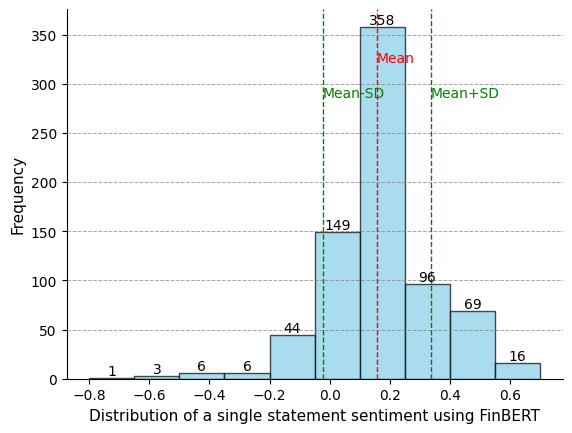

In [10]:
# Change the input data to obtain correct chart

data = grouped["SentimentGenAI"]      #  ["Difference"] ["SentimentRes"] 
mean_val = np.mean(data)
std_val = np.std(data)

# Generate histogram
n, bins, patches = plt.hist(data, bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add text annotations to bars
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2., patches[i].get_height(), str(int(n[i])), 
             ha='center', va='bottom')

# Add vertical lines for mean and standard deviation
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean_val - std_val, color='g', linestyle='dashed', linewidth=1)
plt.axvline(mean_val + std_val, color='g', linestyle='dashed', linewidth=1)

# Add labels for mean and standard deviation
plt.text(mean_val, max(n)*0.9, 'Mean', color='red')
plt.text(mean_val - std_val, max(n)*0.8, 'Mean-SD', color='green')
plt.text(mean_val + std_val, max(n)*0.8, 'Mean+SD', color='green')

# Titles and labels
plt.xlabel('Distribution of a single statement sentiment using FinBERT', fontsize=11) # Difference between FinBERT and GenAI FED sentiments
plt.ylabel('Frequency', fontsize=11)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Soften gridlines
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, color='grey')

# Show the plot

#plt.savefig('HistogramFinBERT.pdf')
plt.show()

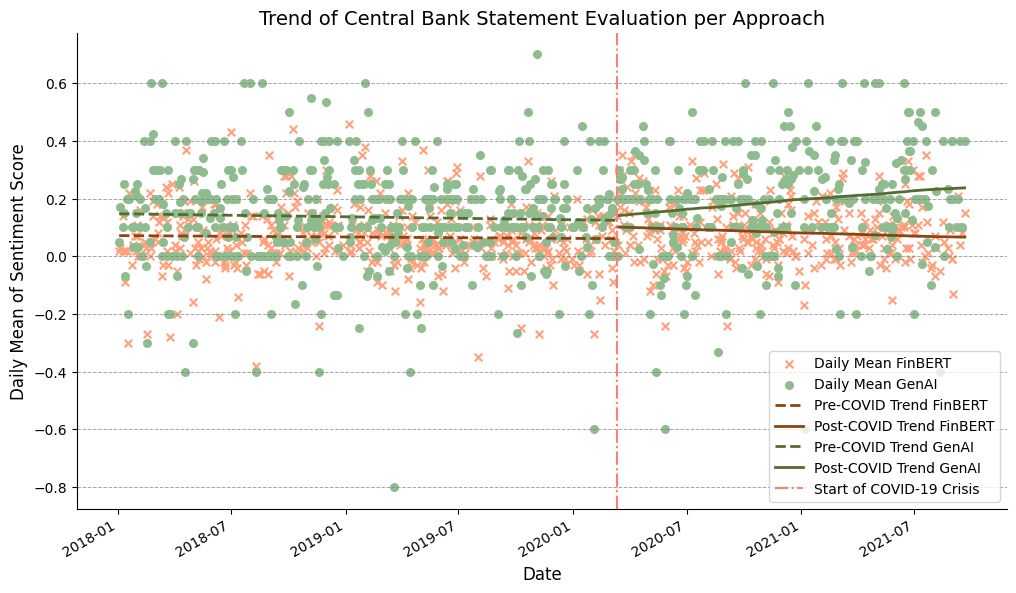

In [25]:
# Convert 'Date' to datetime if it's not already
grouped['Date'] = pd.to_datetime(grouped['Date'])

# Sort the dataframe by Date to ensure the plot is in chronological order
grouped.sort_values('Date', inplace=True)

# Aggregate the data by Date, calculating the mean for each day for both SentimentRes and MeanSent
daily_data = grouped.groupby('Date').agg({'SentimentGenAI': 'mean', 'SentimentFinBERT': 'mean'}).reset_index()

# Mark the start of the COVID-19 crisis
covid_start_date = pd.to_datetime("2020-03-11")

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

# Define the color palette for trend lines and corresponding lighter data points
colors = {
    'SentimentGenAI': {'trend': '#8B4513', 'data': '#FFA07A'},
    'SentimentFinBERT': {'trend': '#556B2F', 'data': '#8fbc8f'}
}

# Plotting data points with lighter shades of the colors
ax.scatter(daily_data['Date'], daily_data['SentimentFinBERT'], color=colors['SentimentGenAI']['data'], label='Daily Mean FinBERT', marker='x', s=30)
ax.scatter(daily_data['Date'], daily_data['SentimentGenAI'], color=colors['SentimentFinBERT']['data'], label='Daily Mean GenAI', marker='o', s=30)

# Function to calculate and plot trend lines with customizable linestyle and linewidth
def plot_trend_lines(dataframe, column_name, color, label_prefix, linestyle='-', linewidth=2):
    slope, intercept, _, _, _ = linregress(range(len(dataframe['Date'])), dataframe[column_name])
    ax.plot(
        dataframe['Date'],
        intercept + slope * np.arange(len(dataframe['Date'])),
        color=color,
        linewidth=linewidth,
        linestyle=linestyle,
        label=label_prefix
    )

# Calculating and plotting trend lines for SentimentRes and MeanSent
plot_trend_lines(
    daily_data[daily_data['Date'] < covid_start_date], 
    'SentimentFinBERT', 
    colors['SentimentGenAI']['trend'], 
    'Pre-COVID Trend FinBERT', 
    linestyle='--',  # Dashed line for pre-COVID
    linewidth=2
)
plot_trend_lines(
    daily_data[daily_data['Date'] >= covid_start_date], 
    'SentimentFinBERT', 
    colors['SentimentGenAI']['trend'], 
    'Post-COVID Trend FinBERT', 
    linestyle='-',  # Solid line for post-COVID
    linewidth=2
)
plot_trend_lines(
    daily_data[daily_data['Date'] < covid_start_date], 
    'SentimentGenAI', 
    colors['SentimentFinBERT']['trend'], 
    'Pre-COVID Trend GenAI', 
    linestyle='--',  # Dashed line for pre-COVID
    linewidth=2
)
plot_trend_lines(
    daily_data[daily_data['Date'] >= covid_start_date], 
    'SentimentGenAI', 
    colors['SentimentFinBERT']['trend'], 
    'Post-COVID Trend GenAI', 
    linestyle='-',  # Solid line for post-COVID
    linewidth=2
)
# Covid Crisis
ax.axvline(x=covid_start_date, color='#fa8072', linestyle='-.', linewidth=1.5, label='Start of COVID-19 Crisis')


ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Mean of Sentiment Score', fontsize=12)
ax.set_title('Trend of Central Bank Statement Evaluation per Approach', fontsize=14)
fig.autofmt_xdate()  
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, color='grey')
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))

#plt.savefig('SentimentTrend.pdf')
plt.show()

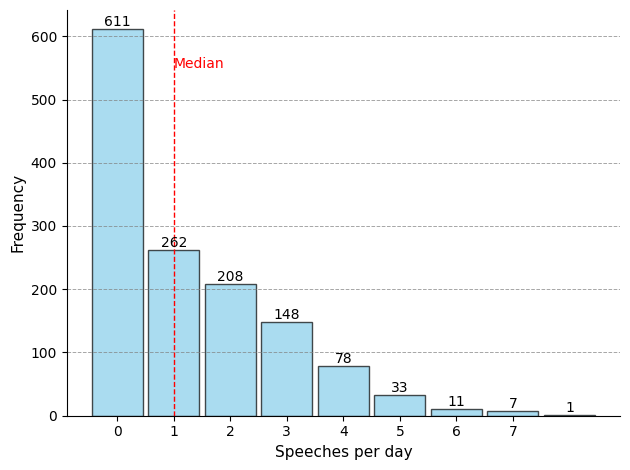

In [23]:
data = AllSpeaches["Date"]
data = data.value_counts()
counts = data.value_counts()
counts[0] = 611
counts = counts.sort_values()
data = counts
# Reconstructing the original data from counts
original_data = []
for idx, value in counts.items():
    original_data.extend([idx] * value)
# Compute the median of the original data
mean_val = np.median(original_data)

# Create bar chart using value_counts data directly
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black', alpha=0.7, width=0.9)

# Add text annotations to bars
for idx, value in counts.items():
    plt.text(idx, value, str(value), ha='center', va='bottom')

# Add vertical line for median
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_val, counts.max() * 0.9, 'Median', color='red')

# Titles and labels
plt.xlabel('Speeches per day', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Soften gridlines
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, color='grey')

# Adjust the x-ticks to include 0
plt.xticks(list(range(8)))

plt.tight_layout()  # To ensure everything fits nicely when saving

# Show the plot
#plt.savefig("HistogramSpeechDist.pdf")
plt.show()